Author: K. V. Shulga (kirill-shulga@oist.jp)

Based on the code of Erika Kawakami and J. Chen and $\textit{Phys. Rev. B} ~\textbf{103}, ~054507 ~(2021)$ by Zadorozhko et al.

In [2]:
%matplotlib inline

In [3]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
#import qutip as qu
import pickle
import scipy.sparse as sp

import importlib
import Lib
importlib.reload(Lib)
from Lib import getXops, getEigMel, getEb0, _izj2, find_nearest 
from Lib import getHamiltonian_z, Hamiltonian_z_solve, getHamiltonian_full, Hamiltonian_full_solve 
from Lib import getHamiltonian, Hamiltonian_solve

# Introduction

Free electrons can be trapped near the surface of liquid helium (at a distance of about 10 nm) due to a weak attraction to the liquid (polarizability of helium atoms) and a repulsion from the helium atoms (Pauli exclusion principle). The basic quantum-mechanical Hamiltonian for a single electron above liquid helium is given by

### $H = \frac{\textbf{P}^2}{2m_e} + V(\textbf{R})$,

where $m_e$ is the bare electron mass. Assuming an infinitely extended flat surface of liquid, the potential energy of an electron can be written as

### $V(\textbf{R}) = V_0 \Theta(-z) - \frac{\Lambda}{z}\Theta(z)$.

Here $z$ is the electron coordinate in the direction perpendicular to the surface, $V_0 \approx 1$ eV is the height of the repulsive potential barrier at $z=0$, and $\Theta(z)$ is the Heaviside (step) function.

### Problem parameters

Physical constants definition (in SI units)

In [4]:
from scipy.constants import e, h, hbar, k, m_e, epsilon_0, mu_0

In [5]:
hb   = hbar                            # Plank constant [Js], or 4.136e-15 [eV s]
qe   = e                               # elementary charge [C]
ep4  = 1.0572                          # the relative permittivity of 4He
ep32 = 1.0462                          # the relative permittivity of 3He
ep3  = 1.042                           # the relative permittivity of 3He (in Monakha's book)
ep0  = epsilon_0                       # the electric constant (vacuum permittivity) [C^2 Nm^-2]
mu0  = mu_0                            # the magnetic constant [Tm/A]
me   = m_e                             # electron mass [kg] or 0.5109 [MeV]
mb   = 9.2740100783e-24                # Bohr Magneton [J T^-1]

The term $\frac{\Lambda}{z}\Theta(z)$ describes attraction of an electron to a weak image charge inside the liquid, where $\Lambda$ is determined by the dielectric constant of liquid helium ε as

### $\Lambda = \frac{e^2}{16\pi\varepsilon_0}\frac{\varepsilon -1}{\varepsilon+1}$.

In [6]:
l4  = qe**2 / 4 * ( ep4 - 1) / ( ep4 + 1) / 4 / ep0 / np.pi     # the Coulomb constant for 4He
l3  = qe**2 / 4 * ( ep3 - 1) / ( ep3 + 1) / 4 / ep0 / np.pi     # the Coulomb constant for 3He (Monakha's book)
l32 = qe**2 / 4 * (ep32 - 1) / (ep32 + 1) / 4 / ep0 / np.pi     # the Coulomb constant for 3He

Define the energy and length scale we choose for $^3$He:

In [7]:
#The whole system uses energy scale of Rydberg_Constant, and length scale of Borh_Radius
    
Rydberg_Constant = me * l3**2/(2 * hb**2)                         # the Rydberg constant for image charge in 3He
Borh_Radius = hb**2/(l3 * me)                                     # the effective Borh radius

The main Hamiltonian can be separated into two parts corresponding to the orbital motion of an electron in the direction perpendicular to the surface ($H_z$) and parallel to the surface. In z-direction, the electron motion is quantized into the surface bound states which are the eigenstates of the Hamiltonian

### $H_z = \frac{p_z^2}{2m_e} + V_0 \Theta(-z) - \frac{\Lambda}{z}\Theta(z) $.

The energy spectrum of this motion can be easily found by making an assumption of a rigid-wall repulsive barrier, that is $V_0 \rightarrow +\infty$. In this case it coincides with the energy spectrum of an electron in the hydrogen atom $−R_e/n^2,~~ n=1,2,..$, where $R_e = m_e\Lambda^2/(2 ̄\hbar^2)$ is the effective Rydberg constant. This constant is about 63 meV (36 meV) for an electron above liquid $^4$He ($^3$He). An electron in the ground Rydberg state localizes above the surface of liquid at an average distance $〈z〉 \approx r_B$, where $r_B = \hbar^2/(\Lambda m_e)$ is the effective Bohr radius. This radius is about 7.8 nm (10.3 nm) for an electron above liquid $^4$He ($^3$He).

In [8]:
# introduce coordinate operators z and 1/z as well as Laplacian in z basis
zgrid, z, zgrid_rev, z_rev, Lapz = getXops(250, zmin = -0.00, zmax = 50, odr = 2)  #2500 points

There is always a static electric field $E_⊥$ applied perpendicular to the liquid surface.  The dc-Stark shift induced by this field provides a way to tune energy difference between the Rydberg states for their spectroscopic studies. It adds an additional term $eE_⊥z$ to the Hamiltonian and changes its eigenenergy spectrum.

In [9]:
Electric_field  = np.linspace(1000, 3500, 100)                            # perpendicular Electric field grid
dcStark_shift = Electric_field  * (qe*Borh_Radius/Rydberg_Constant)       # additional dc-Stark term          

We also introduce a horizontal component of the tilted magnetic field. 
The new (diamagnetic) term appears in this Hamiltonian because of the presence of a parallel component of the magnetic field.

### $H_q = \frac{m_e\omega_y^2z^2}{2}$,

where we define $\omega_y=eB_y/m_e$. 

In [10]:
B_y   = np.linspace(0, 0.2, 100)                                    # grid for horizontal magnetic field B_y       
Omega_y   = B_y * (qe/me*hb/Rydberg_Constant)                     # grid for different \Omega_y values 

Then we construct the Hamiltonian $H_z$ and solve it by finding its eigenvalues as well as $<i|z|j>$ and $ <i|1/z|j>$.

In [11]:
Eigenvalues_z  = []                                               # Eigenvalues of the z-Hamiltonian
i_z_j   = []                                                      # List of <i|z|j> of the z-Hamiltonian
i_z_rev_j  = []                                                   # List of <i|1/z|j> of the z-Hamiltonian

for i in range (len(dcStark_shift)):
    Hamiltonians = [getHamiltonian_z(dcStark_shift[i], Omega_y[j], z, Lapz, zgrid_rev) for j in range(len(Omega_y))]
    eigenvalues, izj, izrevj = Hamiltonian_z_solve(Hamiltonians, z, z_rev, k = 6)
    Eigenvalues_z.append(eigenvalues)
    i_z_j.append(izj)
    i_z_rev_j.append(izrevj)

When an electron are subject to a static magnetic field $B_z$ applied perpendicular to the surface, the electron in-plane motion is quantized into the states with an equidistant energy spectrum $\hbar\omega_c (l+1/2)$ (the Landau levels), where $\omega_c=eB_z/m_e$ is the cyclotron frequency and $l=0,1,..$ is the quantum number. 

The verticaland in-plane motions of an electron are uncoupled, and the full Hamiltonian describing the electron’s orbital motion can be represented as

### $H_0 = H_z + \frac{(\textbf{p}+e\textbf{A})^2}{2m_e} = H_z + \hbar\omega_c(a^{\dagger} a+\frac{1}{2})$,

where $\textbf{A}$ is the vector potential. We define the operator $a = (\sqrt{2}l_B)^{−1}(p_xl^2_B/\hbar-i(x+x_0))$, where $x_0=p_y/(eB_z)$ and $ l_B=\sqrt{\hbar/eB_z}$.  The operator $a$ satisfies the commutation relation $[a,a^{\dagger}] = 1$.


Each electron eigenstate is the product of a Rydberg state $|n〉$ of vertical motion corresponding to the eigenenergy $E_n$ of the Hamiltonian $H_z$ and a state $|l〉$ of in-plane cyclotron motion, where $a^{\dagger}a|l〉=l|l〉$. 

In [12]:
# Dimension of the annihilation and creation operator space
dimension = 20                                  
# annihilation and creation operators
a  = sp.diags(np.sqrt(np.arange(dimension - 1) + 1), 1, dtype = np.double)
ad = a.transpose()
# Patricle number operator
N = ad.dot(a)
# Interaction operator
Int = a + ad

When an additional component of static magnetic field is applied parallel to the liquid surface, in other words when the magnetic field $B$ is tilted with respect to z-axis, the vertical and in-plane motions are coupled. The electron full Hamiltonian becomes

### $H = H_z + \frac{m_e\omega_y^2z^2}{2} + \hbar\omega_c(a^{\dagger} a+\frac{1}{2}) + \frac{\hbar \omega_y}{\sqrt{2}l_B}(a^{\dagger}+a)z$ .

In [13]:
B_z = 0.2085                                                      # fixed value of the B_z field [T]
Omega_c = (qe/me*hb/Rydberg_Constant) * B_z                       # fixed value of the cyclotron frequency
Eigenvalues_full = []                                             # Eigenvalues of the full Hamiltonian
Eigenstates_full = []                                             # Eigenstates of the full Hamiltonian

for i in range(len(dcStark_shift)):
    H_full = [getHamiltonian_full(Eigenvalues_z[i][j], i_z_j[i][j], Omega_c, Omega_y[j], N, Int) for j in range(len(Omega_y))]
    eigenvalues,eigenstates = Hamiltonian_full_solve(H_full)
    Eigenvalues_full.append(eigenvalues)
    Eigenstates_full.append(eigenstates)

In [14]:
p12='figure_0/'                                                       #Folder for saving calculation data

Eigenvalues_full_stack = np.stack(Eigenvalues_full,axis = 1)
Eigenstates_full_stack = np.stack(Eigenstates_full,axis = 1)

pickle.dump (Eigenvalues_z, open(p12 + "Eigenvalues_z.p", "wb" ))
pickle.dump (    i_z_j, open(p12 +  "i_z_j.p", "wb" ))
pickle.dump (i_z_rev_j, open(p12 +  "i_z_rev_j.p", "wb" ))
pickle.dump (Eigenvalues_full_stack, open(p12 + "Eigenvalues_full_stack.p", "wb" ))
pickle.dump (Eigenstates_full_stack, open(p12 + "Eigenstates_full_stack.p", "wb" ))

In [17]:
Frequency_0 = 110                                                   #f_MV frequency [GHz]

## subtract eigenvalues by the lowest one
Eigenvalues = Eigenvalues_full_stack - Eigenvalues_full_stack[:,:,0,None]
Frequencies = Eigenvalues * (Rydberg_Constant/h/1e9)                         

result  = []
for i in range(len(Frequencies)):
    temp_freq = getEb0(Electric_field, Frequencies[i]-Frequency_0)[:,None]
    fields = np.full_like(temp_freq, B_y[i]) #Return a full array with the same shape and type as a given array.
    full_list = np.hstack([fields, temp_freq])
    result.append(full_list)
    
dots = np.vstack(result)

In [18]:
i_z2_j = []
f_temp = Frequencies - Frequency_0

for i in range(len(dots)):
    idx0 = find_nearest(B_y, dots[i][0])
    idx1 = find_nearest(Electric_field, dots[i][1])
    idx2 = find_nearest(f_temp[idx0,idx1],0)
    
    #return the value |<i|z|j>|^2
    i_z2_j.append( _izj2(Eigenstates_full_stack[idx0, idx1,:,0], Eigenstates_full_stack[idx0, idx1,:,idx2], i_z_j[idx1][idx0]))
    
i_z2_j = np.stack(i_z2_j)   

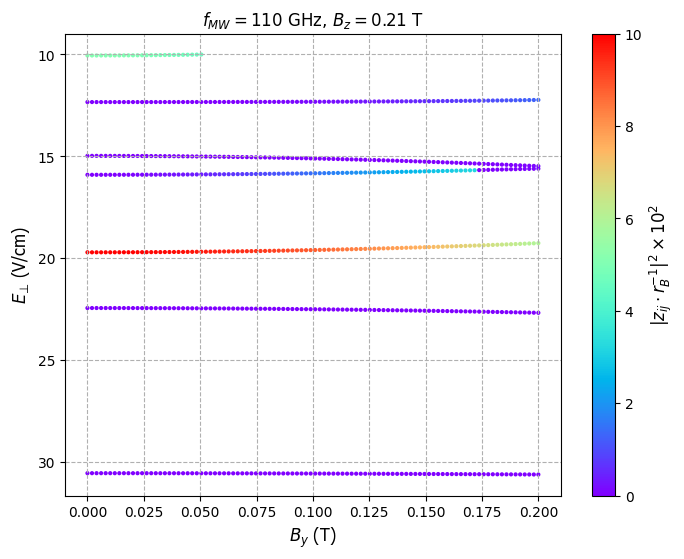

In [19]:
hfont = {'fontname':'Tahoma'}
fig, axes = plt.subplots(1,1,figsize=(8, 6))
p = plt.scatter(dots[:,0], dots[:,1]/100, s = 4, c = i_z2_j * 100, cmap=cm.rainbow, marker = 'o', norm = plt.Normalize(0,10))

#axes.set_ylim(10, 35)
#axes.set_xlim(0, 1.0)
axes.invert_yaxis()
axes.set_title(r'$f_{{MW}}={}$ GHz, $B_z ={:.2f}$ T'.format(Frequency_0, B_z),fontsize='large')
axes.set_ylabel(r'$E_\bot$ (V/cm)', fontsize='large', **hfont)
axes.set_xlabel(r'$B_y$ (T)', fontsize='large', **hfont)
plt.grid(True, 'major', linestyle='--')

cb = fig.colorbar(p)
cb.set_label(r'$|z_{{ij}} \cdot r_B^{-1} |^2  \times10^{2}$', fontsize='large', **hfont) 


#ymin, ymax = axes.get_ylim()
#axes.set_yticks(np.round(np.linspace(ymin, ymax, 5), 2))
#xmin, xmax = axes.get_xlim()
#axes.set_xticks(np.round(np.linspace(xmin-1, xmax, 4), 2))

#matplotlib.pyplot.text(3, 0.19,'(a)', fontsize=35, weight="black",  verticalalignment='center')

fig.savefig(p12 + "by-v-color,bz={:.2f},fmw={:.1f}.pdf".format(B_z, Frequency_0), bbox_inches='tight')
fig.savefig(p12 + "by-v-color,bz={:.2f},fmw={:.1f}.png".format(B_z, Frequency_0), bbox_inches='tight',dpi = 300)
plt.show()

# Now sweep $B_z$ with fixed $B_y$ and $E_\perp$ and find the frequency distribution.

In [20]:
# introduce coordinate operators z and 1/z as well as Laplacian in z basis
zgrid, z, zgrid_rev, z_rev, Lapz = getXops(2500, zmin = -0.00, zmax = 50, odr = 2)  #2500 points

In [21]:
Electric_field  = 3.5*5*100                                                 # perpendicular Electric field [V/cm*100]
dcStark_shift = Electric_field  * (qe*Borh_Radius/Rydberg_Constant)      # additional dc-Stark term   
B_y   = 0.03                                                              # horizontal magnetic field B_y [T]
Omega_y   = B_y * (qe/me*hb/Rydberg_Constant)                            # \Omega_y value
B_z = np.linspace(0, 0.5, 350)                                    # grid for vertical magnetic field B_z field [T]
#B_z = np.linspace(0, 0.5, 500)                                    # grid for vertical magnetic field B_z field [T]
Omega_c = (qe/me*hb/Rydberg_Constant) * B_z                       # grid for different cyclotron frequencies 

Frequency_0 = 90                                                         #f_MV frequency [GHz]

In [22]:
# Dimension of the annihilation and creation operator space
dimension = 20                                  
# annihilation and creation operators
a  = sp.diags(np.sqrt(np.arange(dimension - 1) + 1), 1, dtype = np.double)
ad = a.transpose()
# Patricle number operator
N = ad.dot(a)
# Interaction operator
Int = a + ad

In [23]:
Eigenvalues_full = []                                             # Eigenvalues of the full Hamiltonian
Eigenstates_full = []                                             # Eigenstates of the full Hamiltonian

for i in range(len(Omega_c)):
    H_full = getHamiltonian(dcStark_shift, z, Lapz, zgrid_rev, Omega_c[i], Omega_y, N, Int)
    eigenvalues,eigenstates = Hamiltonian_solve(H_full)
    Eigenvalues_full.append(eigenvalues)
    Eigenstates_full.append(eigenstates)

In [24]:
p12='figure_1/'                                                       #Folder for saving calculation data

Eigenvalues_full_stack = np.stack(Eigenvalues_full,axis = 1)
Eigenstates_full_stack = np.stack(Eigenstates_full,axis = 1)

pickle.dump (Eigenvalues_full_stack, open(p12 + "Eigenvalues_full_stack.p", "wb" ))
pickle.dump (Eigenstates_full_stack, open(p12 + "Eigenstates_full_stack.p", "wb" ))

In [25]:
## subtract eigenvalues by the lowest one
Eigenvalues = Eigenvalues_full_stack - Eigenvalues_full_stack[:,0,None]
Frequencies = Eigenvalues * (Rydberg_Constant/h/1e9)

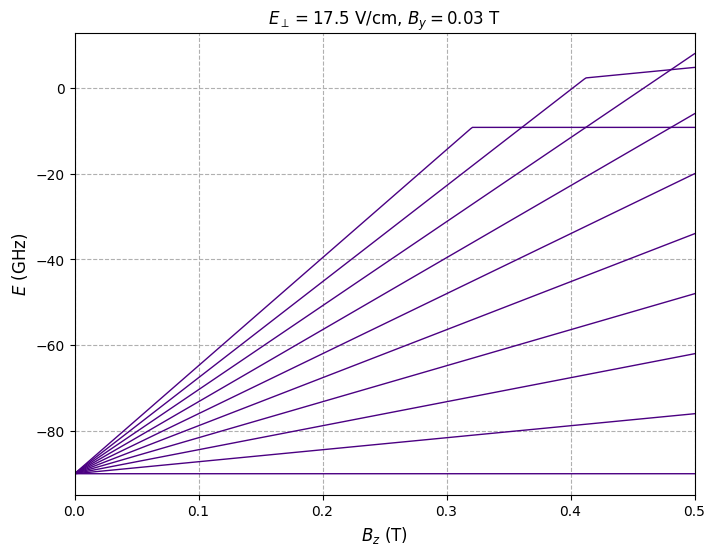

In [26]:
fig, axes = plt.subplots(1,1,figsize=(8, 6))
for i in arange(10):
    #p = plt.scatter(B_z, Frequencies[i], s = 2, color = 'b', marker = 'o', norm = plt.Normalize(0,10))
    p = plt.plot(B_z, Frequencies[i]-Frequency_0, color = '#4b0082', linewidth = 1)

#axes.set_ylim(-91, -80)
axes.set_xlim(0.0, 0.5)
#axes.invert_yaxis()
axes.set_title(r'$E_{{\perp}}={}$ V/cm, $B_y ={:.2f}$ T'.format(Electric_field/100, B_y), fontsize = 'large')
axes.set_ylabel(r'$E$ (GHz)', fontsize = 'large')
axes.set_xlabel(r'$B_z$ (T)', fontsize = 'large')
plt.grid(True, 'major', linestyle = '--')

fig.savefig(p12 + "bz-vs-energy,By={:.2f},Ez={:.1f}.pdf".format(B_y, Electric_field), bbox_inches='tight')
fig.savefig(p12 + "bz-vs-energy,By={:.2f},Ez={:.1f}.png".format(B_y, Electric_field), bbox_inches='tight',dpi = 300)
plt.show()

In [27]:
from matplotlib.colors import ListedColormap
cmap0  = plt.cm.viridis
my_cm  = cmap0(np.flip(np.arange(cmap0.N)))
my_cm[:,-1] = np.linspace(0, 1, cmap0.N)**.5
my_cm  = ListedColormap(my_cm)

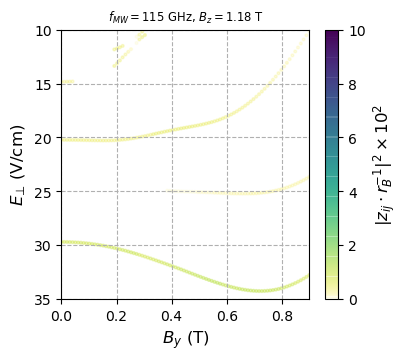

In [31]:
plt.style.use('default')
fig,ax = plt.subplots(figsize = (4, 3.5))
pic = plt.scatter(dots[:,0], dots[:,1]/100, s = 4, c = z2s * 100, cmap = my_cm, marker = 'o',norm = plt.Normalize(0,10))
ax.set_ylim(10, 35)
ax.set_xlim(0, .9)
ax.invert_yaxis()
ax.set_title(r'$f_{{MW}}={}$ GHz, $B_z ={:.2f}$ T'.format(Frequency_0, B_z),fontsize='small')
plt.ylabel(r'$E_\bot$ (V/cm)', fontsize='large')
plt.xlabel(r'$B_y$ (T)', fontsize='large')
plt.grid(True, 'major', linestyle='--')

cb = fig.colorbar(pic)
cb.set_label(r'$|z_{{ij}} \cdot r_B^{-1} |^2  \times10^{2}$', fontsize='large') #r_B^{{-2}}

fig.savefig(p12 + "by-v-color,bz={:.2f},fmw={:.1f}.pdf".format(B_z,Frequency_0), bbox_inches='tight')
fig.savefig(p12 + "by-v-color,bz={:.2f},fmw={:.1f}.png".format(B_z,Frequency_0), bbox_inches='tight',dpi = 300)
plt.show()
#plt.close()

In [17]:
def spines(ax=None):
    if ax is None:
        ax = plt.gca()
    dict(ax.spines.items())["left"].set_position(('outward', 10))
    dict(ax.spines.items())["bottom"].set_position(('outward', 10))
    dict(ax.spines.items())["top"].set_position(('outward', 10))
    dict(ax.spines.items())["right"].set_position(('outward', 10))
    
def annotate_distance(ax, text, point1, point2, linestyle, fontsize, textoffset = (0.1,0)):
    ax.annotate('', point1, point2, \
            arrowprops={'arrowstyle':'<->', 'linestyle':linestyle, "facecolor":"black"}, fontsize=fontsize);
    ax.annotate(text, point1, (0.5*(point1[0]+point2[0])+textoffset[0], 0.5*(point1[1]+point2[1])+textoffset[1]),
                fontsize=fontsize)

In [18]:
mpl.style.use('default')